# 0) При реализации алгоритма разрешается использовать только библиотеки из requierments.txt

В него входит:
1. jupyter - библиотека для показа ноутбуков
2. numpy - библиотека для вычислений
3. matplotlib - библиотека для визуализации

## Установка 
1. Устанавливаем python3 и virtualenv
2. создаем окружение virtualenv --no-site-packages  lin_prog
3. активируем окружение source activate lin_prog
4. устанавливаем зависимости pip install -r requirements.txt
5. запускаем jupyter и начинаем работать jupyter notebook

# ============================================================
# Задача на Симплекс метод

## 1) На вход Вашему функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

## 2) На выход программа должна выдавать:

### Обязательная часть (0.3 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


### Дополнительная часть  (0.8 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [59]:
import numpy as np
# Не печатать в лог сообщения о делении на ноль, ибо так и должно быть
np.seterr(divide='ignore', invalid='ignore')
import logging as log
import sys
log.basicConfig(level=log.DEBUG, format='>%(message)s', stream=sys.stdout)

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

#пример из листочка 1
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
# (array([ 4.,  0.]), 20.0, 1)

epsilon=0.0000001

#TODO: у задач с отрицательными бэшками проверить корректность значения целевой функции.

In [60]:
class SP:
    def __init__(self, A, b, c, c_old=None):
        self.A = A
        b = b.reshape((-1, 1)).astype(np.float64)
        self.b = b
        self.c = c
        
        self.n = n = A.shape[0]
        self.m = m = A.shape[1]
        #log.info('n=%s, m=%s'%(n, m))

        self.basis = np.array(list(range(0, n)))
        self.nonbasis = np.array(list(range(n, n+m)))
        #log.debug("basis %s, nonbasis %s"%(self.basis, self.nonbasis))
        
        # Сделаем симплекс-таблицу.
        self.ST = np.block([[A,  b], 
                      [-c, 0]]).astype(np.float64)
        #log.info('%s'%self.ST)
        if c_old is None:
            self.c_old = None
        else:
            self.c_old = c_old
    
    def from_ST(self, ST, basis, nonbasis):
        self.ST = ST
    
    def get_solution(self):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        x = np.zeros(m)
        w = np.zeros(n)
        for i in range(0, n):
            if 0<=basis[i]<n:
                w[basis[i]] = ST[:,-1][i]
            if basis[i]>=n:
                x[basis[i]-n] = ST[:,-1][i]
        log.info('x=%s, w=%s', x, w)
        if (self.A@x > self.b.reshape(1,-1)[0]).any() or (x < 0).any():
            raise Exception('Solution is infeasible')
        return x, w
    
    def __get_variables(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        if method=='init_auxilary':
            if (ST[:, -1] > 0).all():
                raise Exception('Problem is unbounded')
            #########i = np.argmin(ST[:, -1])
            i = np.argmin(ST[:, -1][:-1])
            j = m-1
            log.info('j=%s'%j)
            log.info('i=%s'%i)
            return i, j
        if method=='largest_coef':
            j = np.argmin(ST[-1][:-1])
        elif method=='blend':
            #j = np.argmin(np.ma.array(nonbasis, mask=(ST[-1][:-1]>=0)))
            j = nonbasis[(ST[-1][:-1]<0)][0]
        elif method=='lexical':
            j = np.argmin(ST[-1][:-1]) # любой
        else:
            raise Exception('Unknown method')
        
        log.info('j=%s'%j)
        ratios = ST[:, -1]/ST[:, j]
        log.debug('%s'%ratios)
        if (ratios[:-1]<0).all():
            raise Exception('Problem is unbounded')
            
        i = np.argmin(np.ma.array(ratios[:-1], mask=(ratios[:-1]<0)))
        
        # Если у нас есть неоднозначность выбора и лексикографический метод
        if np.count_nonzero(ratios[:-1] == i)>1 and method=='lexical':
            ratios = ST / ST[:, j].reshape(-1,1)
            print(ratios, ST[:, j].reshape(-1,1))
            print(ratios[:-1], ratios[:-1, j]<0)
            array_mask = np.zeros_like(ratios[:-1])
            array_mask[ratios[:-1, j]<0] = 0
            array_mask[(ratios[:-1] != i)] = 1
            print(array_mask)
            #arr = np.ma.mask_rows(np.ma.array(ratios[:-1], mask=(ratios[:-1, j]<0)))
            srt = np.lexsort(np.ma.array(ratios[:-1], mask=array_mask).T)
            print(srt)
            i = srt[0]
        log.info('i=%s'%i)
        return i, j
    
    def make_iteration(self, method):
        ST = self.ST
        basis = self.basis
        nonbasis = self.nonbasis
        n = self.n
        m = self.m
        
        #Разрешающий столбец
        i, j = self.__get_variables(method)

        basis[i], nonbasis[j] = nonbasis[j], basis[i]
        log.info("basis %s, nonbasis %s"%(basis, nonbasis))
        
        #Строим новую таблицу
        
        ST_ = -ST.copy()
        if self.c_old is not None:
            c_old = self.c_old.copy()
        
        ST_[i] = np.zeros(ST_.shape[1])
        ST_[i][j] = 1
        
        # S - матрица перехода
        S = np.eye(ST_.shape[1])
        S[j] = -ST[i]
        
        ST_ = -(np.linalg.inv(S.T)@ST_.T).T
        if self.c_old is not None:
            #c_old = (np.linalg.inv(S.T)@c_old.reshape(-1,1)).T[0]
            c_old = (np.linalg.inv(S.T)@c_old).T
#         ST_[i][j] = 1/ST[i][j]
#         log.debug("%s"%ST_)
#         ST_[i][np.arange(m+1) != j] = ST[i][np.arange(m+1) != j]/ST[i][j]
#         log.debug("%s"%ST_)
#         ST_[:, j][np.arange(n+1) != i] = -ST[:, j][np.arange(n+1) != i]/ST[i][j]
#         if sp.c_old is not None:
#             c_old[j] = -sp.c_old[j]/ST[i][j]
#         log.debug("%s"%ST_)

#         for i_ in range(0, n+1):
#             for j_ in range(0, m+1):
#                 if i_ != i and j_ != j:
#                     ST_[i_][j_] = ST[i_][j_] - ST[i_][j]*ST[i][j_]/ST[i][j]
#                     if sp.c_old is not None and i_ == n and j_ != m:
#                         c_old[j_] = sp.c_old[j_] - ST[i_][j]*ST[i][j_]/ST[i][j]

        self.ST = ST_
        if self.c_old is not None:
            self.c_old = c_old
        
        log.info("%s"%self)
        return self
    
    def __str__(self):
        return "%s\nn=%s, m=%s, basis=%s, nonbasis=%s with c_old=%s"%(
            self.ST, self.n, self.m, self.basis, self.nonbasis, self.c_old)


In [61]:
def draw_all(sp, path):
    
    A = sp.A
    b = sp.b
    #c = sp.c
    
    def is_valid_solution(x):
        epsilon = 0.00001
        return (A@x.reshape((-1,1))<=b+epsilon).all() and (x>=0-epsilon).all()

    # Добавляем прямые ограничений типа >=0 в матрицы.
    A_plot = np.vstack([A, np.array([[1,0], [0,1]])])
    b_plot = np.vstack([b, [[0],[0]]])

    num_iter = len(path)
    plt.figure(figsize=(5, 5*(num_iter+1)))
    # Рисует ограничения, допустимые угловые точки отмечает чёрными точками, текущую - красной.
    for i, x in enumerate(path):
        plt.subplot(num_iter, 1, i+1)
        a = plt.gca()
        #plt.axes().set_aspect('equal')#, 'datalim')
        ##a.axis([-1, 17, -1, 17])
        a.set_aspect('equal')
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        plt.title('Iteration %d x=(%.2f, %.2f)' % (i+1,x[0],x[1]))

        xmax, ymax = 0,0
        # Пересечения
        for i in range(0, A_plot.shape[0]):
            for j in range(0, i):
                if i != j:
                    a_, b_ = A_plot[i]
                    c_ = b_plot[i][0]
                    d_, e_ = A_plot[j]
                    f_ = b_plot[j][0]
                    #print(a_, b_, c_, d_, e_, f_)
                    x_ = (b_*f_-c_*e_)/(b_*d_-a_*e_)
                    y_ = (c_*d_-a_*f_)/(b_*d_-a_*e_)#(c_-a_*x_)/b_
                    if x_ > xmax and x_ != np.inf:
                        xmax = x_
                    if y_ > ymax and y_ != np.inf:
                        ymax = y_
                    #print(x_, y_)
                    if is_valid_solution(np.array([x_, y_])):
                        plt.scatter([x_], [y_], color='black', zorder=10)
        plt.scatter([x[0]], [x[1]], color='red', zorder=11)

        #print('xmax ymax', xmax, ymax)
        # Ограничения в виде осей (неотрицательность переменных)
        plt.plot([0, xmax], [0, 0], color='blue')
        plt.plot([0, 0], [ymax, 0], color='blue')
        epsilon = 2
        plt.xlim((-epsilon, xmax+epsilon))
        plt.ylim((-epsilon, ymax+epsilon))

        # Ограничения
        for i in range(0, A_plot.shape[0]):
            a_, b_ = A_plot[i]
            c_ = b_plot[i][0]
            #print(a_, b_, c_)
            #print(c_/b_, c_/a_)
            #plt.plot([0, c_/a_], [c_/b_, 0], color='blue')

            if c_/b_<0:
                x1, y1 = c_/a_, 0
            else:
                x1, y1 = 0, c_/b_
            if (c_-a_*xmax)/b_ > ymax:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            else:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue')

            if c_/a_<0:
                x1, y1 = 0, c_/b_
            else:
                x1, y1 = c_/a_, 0
            if (c_-a_*xmax)/b_ < ymax:
                x2, y2 = xmax, (c_-a_*xmax)/b_
            else:
                x2, y2 = (c_-b_*ymax)/a_, ymax
            if y2 < 0:
                x2, y2 = c_/a_, 0
            if x2 < 0:
                x2, y2 = 0, c_/b_
            plt.plot([x1, x2], [y1, y2], color='blue', zorder=-1)

            # Дорисовываем оси до нашей точки.
            #plt.plot([0, c_/a_], [0, 0], color='blue')
            #plt.plot([0, 0], [c_/b_, 0], color='blue')


    #plt.tight_layout()
    plt.show()

In [62]:
def solve_lin_prog (A, b, c, method='blend', start_point=None, draw=False):
    """
    Здесь должно быть ваше решение. У всех действий должны быть комментарии. 
    Код должен быть читабельным, хорошо использовать дополнительные функции если это необходимо
    
    A, b, c - матрица, b - вектор ограничений типа <=, с - функция полезности, задача максимизации
    method - 'blend', 'lexical'
    start_point - точка
    draw -  true/false рисовать ли ответ, только для 2 переменных
    
    Вывод - вектор на котором достигается максимум, максимальное значение, число итераций
    """
    
    sp = None
    
    # Если есть отрицательные значения в b, запускаем инициализацию
    if (b < 0).any():
        print('INITIAL PROBLEM:')
        print(SP(A, b, c))
        
        log.info("             AUXILARY PROBLEM:")
        A_ = np.hstack([A, -np.ones((A.shape[0], 1))])
        b_ = b
        c_ = np.hstack([np.zeros(A.shape[1]), [-1]])
        sp = SP(A_, b_, c_, c_old=np.hstack([c.copy(), [0, 0]]))
        print(sp)
        
        log.info("First step")
        sp = sp.make_iteration('init_auxilary')
        
        
        iteration_number = 0
        #while np.min(sp.ST[-1][:-1]) < 0:
        while (sp.ST[-1][:-1] < 0).any():
            iteration_number += 1
            log.info('          AUXILARY ITERATION #%s'%iteration_number)

            sp = sp.make_iteration(method)

            x, w = sp.get_solution()
        
        i = np.argwhere(sp.nonbasis == sp.n+sp.m-1)[0][0]
        sp.ST = np.delete(sp.ST, i, 1)
        print(sp.c_old)
        
        #sp.c = np.delete(sp.c_old, i)
        sp.c = -c
        sp.A = A
        sp.b = b.reshape(-1,1)
        sp.ST[-1] = -np.delete(sp.c_old, i)
        sp.nonbasis = np.delete(sp.nonbasis, i)
        sp.m -= 1
        sp.c_old = None
    else:
        sp = SP(A, b, c)
    
    print("SOLVING PROBLEM:")
    print(sp)
    
    iteration_number = 0
    
    
    # Начальное решение
    x, w = sp.get_solution()
    
    solutions = [x]
    
    while (sp.ST[-1][:-1] < 0).any():
        iteration_number += 1
        log.info('          ITERATION #%s'%iteration_number)
        
        sp = sp.make_iteration(method)
        
        x, w = sp.get_solution()
        solutions.append(x)
    
    log.info('FINISHED in %d iterations'%iteration_number)
    
    log.info('path %s'%solutions)
    x, w = sp.get_solution()
    
    log.info('SOLUTIONS %s'%solutions)
    
    if draw == True and sp.m != 2:
        raise Warning("Can't draw with dim != 2")
        
    if draw == True:
        draw_all(sp, solutions)
    
    return x, sp.ST[-1][-1], iteration_number


def solve_dual(A, b, c, draw=False):
    return solve_lin_prog(-A.T, -c, -b, draw=draw)

SOLVING PROBLEM:
[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 5.  8.]
>          ITERATION #1
>j=0
>[ 5.  4. -0.]
>i=1
>basis [0 2], nonbasis [1 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
n=2, m=2, basis=[0 2], nonbasis=[1 3] with c_old=None
>x=[ 4.  0.], w=[ 1.  0.]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>x=[ 4.  0.], w=[ 1.  0.]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.,  0.])]


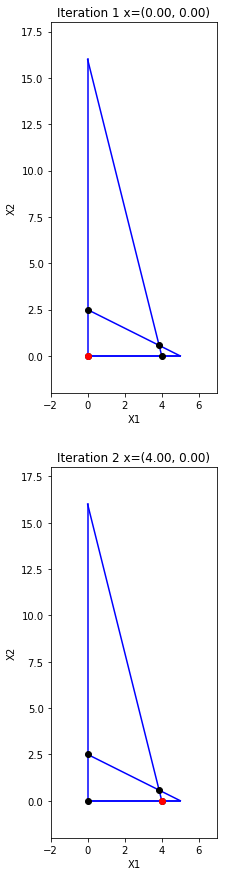

In [63]:
method = 'largest_coef'

A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
# Тест лексикографического
ans = solve_lin_prog(A, b, c, method='lexical', draw=True)

INITIAL PROBLEM:
[[-1.  1. -1.]
 [-1. -2. -2.]
 [ 0.  1.  1.]
 [ 2.  1.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  1. -1. -1.]
 [-1. -2. -1. -2.]
 [ 0.  1. -1.  1.]
 [-0. -0.  1.  0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 5 2], nonbasis [3 4 1]
>[[-0.  3. -1.  1.]
 [ 1.  2. -1.  2.]
 [ 1.  3. -1.  3.]
 [-1. -2.  1. -2.]]
n=3, m=3, basis=[0 5 2], nonbasis=[3 4 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=1
>[ 0.33333333  1.          1.          1.        ]
>i=0
>basis [4 5 2], nonbasis [3 0 1]
>[[-0.          0.33333333 -0.33333333  0.33333333]
 [ 1.         -0.66666667 -0.33333333  1.33333333]
 [ 1.         -1.         -0.          2.        ]
 [-1.          0.66666667  0.33333333 -1.33333333]]
n=3, m=3, basis=[4 5 2], nonbasis=[3 0 1] with c_old=[-2.          0.33333333 -0.33333333  0.33333333]
>x=[ 0.          0.33333333  1.33333333], w=[ 0.  

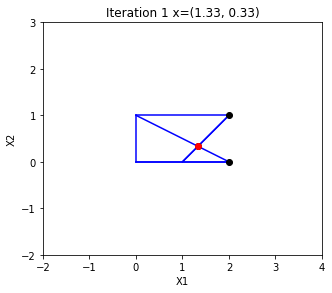

In [64]:
# Тест инициализации
A=np.array([[-1,1],[-1, -2], [0, 1]])
b=np.array([-1, -2, 1])
c=np.array([-2, -1])
ans = solve_lin_prog(A, b, c, method='largest_coef', draw=True)

In [65]:
# Пример неограниченной задачи
A=np.array([[-1,-1],[-2, -1]])
b=np.array([1, 2])
c=np.array([2, 1])
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)

# A = np.array([[-4,-2],[-2,0], [3,2],[-1,3], [0,-3]])
# b = np.array([-8,-2,10,1,-2])
# c = np.array([-3,4])

SOLVING PROBLEM:
[[-1. -1.  1.]
 [-2. -1.  2.]
 [-2. -1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 1.  2.]
>          ITERATION #1
>j=0
>[-1. -1. -0.]
Problem is unbounded


In [66]:
# Пример недопустимой задачи
A=np.array([[1,1],[-1, -1]])
b=np.array([1, -2])
c=np.array([-2, -1])

ans = solve_lin_prog(A, b, c, method=method, draw=True)
try:
    ans = solve_lin_prog(A, b, c, method=method, draw=True)
except Exception as e:
    print(e)

INITIAL PROBLEM:
[[ 1.  1.  1.]
 [-1. -1. -2.]
 [ 2.  1.  0.]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[ 1.  1. -1.  1.]
 [-1. -1. -1. -2.]
 [-0. -0.  1.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-2 -1  0  0]
>First step
>j=2
>i=1
>basis [0 4], nonbasis [2 3 1]
>[[ 2.  2. -1.  3.]
 [ 1.  1. -1.  2.]
 [-1. -1.  1. -2.]]
n=2, m=3, basis=[0 4], nonbasis=[2 3 1] with c_old=[-2. -1.  0.  0.]
>          AUXILARY ITERATION #1
>j=0
>[ 1.5  2.   2. ]
>i=0
>basis [2 4], nonbasis [0 3 1]
>[[ 0.5  1.  -0.5  1.5]
 [-0.5 -0.  -0.5  0.5]
 [ 0.5 -0.   0.5 -0.5]]
n=2, m=3, basis=[2 4], nonbasis=[0 3 1] with c_old=[ 1.  1. -1.  3.]
>x=[ 1.5  0.   0.5], w=[ 0.  0.]


IndexError: index 0 is out of bounds for axis 0 with size 0

SOLVING PROBLEM:
[[ 1.   2.   5. ]
 [ 2.   0.5  8. ]
 [-5.  -1.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>x=[ 0.  0.], w=[ 5.  8.]
>          ITERATION #1
>j=0
>[ 5.  4. -0.]
>i=1
>basis [0 2], nonbasis [1 3]
>[[ -0.5    1.75   1.  ]
 [  0.5    0.25   4.  ]
 [  2.5    0.25  20.  ]]
n=2, m=2, basis=[0 2], nonbasis=[1 3] with c_old=None
>x=[ 4.  0.], w=[ 1.  0.]
>FINISHED in 1 iterations
>path [array([ 0.,  0.]), array([ 4.,  0.])]
>x=[ 4.  0.], w=[ 1.  0.]
>SOLUTIONS [array([ 0.,  0.]), array([ 4.,  0.])]


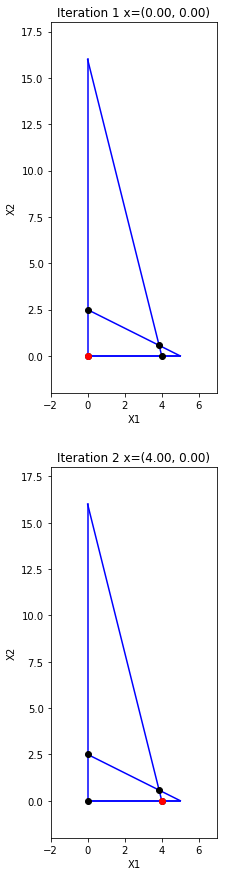

INITIAL PROBLEM:
[[-1.  -2.  -5. ]
 [-2.  -0.5 -1. ]
 [ 5.   8.   0. ]]
n=2, m=2, basis=[0 1], nonbasis=[2 3] with c_old=None
>             AUXILARY PROBLEM:
[[-1.  -2.  -1.  -5. ]
 [-2.  -0.5 -1.  -1. ]
 [-0.  -0.   1.   0. ]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=[-5 -8  0  0]
>First step
>j=2
>i=0
>basis [4 1], nonbasis [2 3 0]
>[[ 1.   2.  -1.   5. ]
 [-1.   1.5 -1.   4. ]
 [-1.  -2.   1.  -5. ]]
n=2, m=3, basis=[4 1], nonbasis=[2 3 0] with c_old=[-5. -8.  0.  0.]
>          AUXILARY ITERATION #1
>j=2
>[-5. -4. -5.]
Problem is unbounded
SOLVING PROBLEM:
[[ 1. -1.  1.]
 [ 2. -1.  3.]
 [ 0.  1.  5.]
 [-4. -3.  0.]]
n=3, m=2, basis=[0 1 2], nonbasis=[3 4] with c_old=None
>x=[ 0.  0.], w=[ 1.  3.  5.]
>          ITERATION #1
>j=0
>[ 1.   1.5  inf -0. ]
>i=0
>basis [3 1 2], nonbasis [0 4]
>[[ 1. -1.  1.]
 [-2.  1.  1.]
 [-0.  1.  5.]
 [ 4. -7.  4.]]
n=3, m=2, basis=[3 1 2], nonbasis=[0 4] with c_old=None
>x=[ 1.  0.], w=[ 0.  1.  5.]
>          ITERATION #2
>j=1
>[-1.      

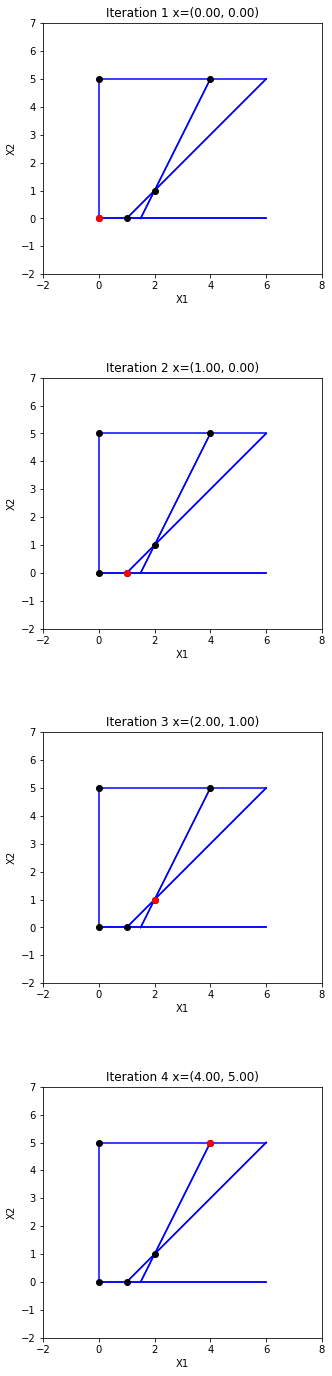

INITIAL PROBLEM:
[[-1. -2.  0. -4.]
 [ 1.  1. -1. -3.]
 [ 1.  3.  5.  0.]]
n=2, m=3, basis=[0 1], nonbasis=[2 3 4] with c_old=None
>             AUXILARY PROBLEM:
[[-1. -2.  0. -1. -4.]
 [ 1.  1. -1. -1. -3.]
 [-0. -0. -0.  1.  0.]]
n=2, m=4, basis=[0 1], nonbasis=[2 3 4 5] with c_old=[-1 -3 -5  0  0]
>First step
>j=3
>i=0
>basis [5 1], nonbasis [2 3 4 0]
>[[ 1.  2. -0. -1.  4.]
 [ 2.  3. -1. -1.  1.]
 [-1. -2. -0.  1. -4.]]
n=2, m=4, basis=[5 1], nonbasis=[2 3 4 0] with c_old=[-1. -3. -5.  0.  0.]
>          AUXILARY ITERATION #1
>j=2
>[-inf  -1.  inf]
Problem is unbounded
SOLVING PROBLEM:
[[  2.   3.   1.   5.]
 [  4.   1.   2.  11.]
 [  3.   4.   2.   8.]
 [ -5.  -4.  -3.   0.]]
n=3, m=3, basis=[0 1 2], nonbasis=[3 4 5] with c_old=None
>x=[ 0.  0.  0.], w=[  5.  11.   8.]
>          ITERATION #1
>j=0
>[ 2.5         2.75        2.66666667 -0.        ]
>i=0
>basis [3 1 2], nonbasis [0 4 5]
>[[  0.5   1.5   0.5   2.5]
 [ -2.   -5.   -0.    1. ]
 [ -1.5  -0.5   0.5   0.5]
 [  2.5   3.5 

In [68]:
A=np.array([[1,2],[2,0.5]])
b=np.array([5,8])
c=np.array([5,1])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
corr_ans = (np.array([ 4.,  0.]), 20.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    print(solve_dual(A, b, c, draw=True))
except Exception as e:
    print(e)

A=np.array([[1,-1],[2,-1], [0, 1]])
b=np.array([1,3,5])
c=np.array([4,3])
ans = solve_lin_prog(A, b, c, draw=True, method=method)
corr_ans = (np.array([ 4.,  5.]), 31.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
try:
    print(solve_dual(A, b, c, draw=True))
except Exception as e:
    print(e)
#print(is_optimal(A,b,c,x))

A=np.array([[2,3,1],[4,1,2],[3,4,2]])
b=np.array([5, 11, 8])
c=np.array([5, 4, 3])
ans = solve_lin_prog(A, b, c, method=method)
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
#print(solve_dual(A, b, c))

A=np.array([[1,1,1,1],[2,1,-1,-1],[0,-1,0,1]])
b=np.array([40, 10, 10])
c=np.array([0.5, 3,1,4])
ans = solve_lin_prog(A, b, c, method=method)
corr_ans = (np.array([  0.,  15.,   0.,  25.]), 145.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])
#print(solve_dual(A, b, c))

In [22]:
# Пример, который циклится
A=np.array([[0.5,-3.5,-2, 4],[0.5, -1, -0.5, 0.5], [1, 0, 0, 0]])
b=np.array([0,0,1])
c=np.array([1, -2, 0, -2])
ans = solve_lin_prog(A, b, c, method='blend')
corr_ans = (np.array([ 2.,  0.,  1.]), 13.0)
assert((ans[0] == corr_ans[0]).all() and ans[1] == corr_ans[1])

SOLVING PROBLEM:
[[ 0.5 -3.5 -2.   4.   0. ]
 [ 0.5 -1.  -0.5  0.5  0. ]
 [ 1.   0.   0.   0.   1. ]
 [-1.   2.   0.   2.   0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[ 0.  0.  1.]
>          ITERATION #1
>j=3
>[  0.   0.  inf   0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #2
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #3
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -

>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #25
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #26
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #27
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #50
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #51
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #52
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[

>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #75
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #76
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #77
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], 

>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #100
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #101
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #102
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], 

>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #125
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #126
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #127
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.

>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #149
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2], nonbasis=[3 4 5 0] with c_old=None
>x=[ 0.  0.  0. -0.], w=[ 0. -0.  1.]
>          ITERATION #150
>j=3
>[ -0.   0. -inf   0.]
>i=0
>basis [0 1 2], nonbasis [3 4 5 6]
>[[ 0.5 -3.5 -2.   4.  -0. ]
 [ 0.5 -1.  -0.5  0.5 -0. ]
 [ 1.  -0.  -0.  -0.   1. ]
 [-1.   2.  -0.   2.  -0. ]]
n=3, m=4, basis=[0 1 2], nonbasis=[3 4 5 6] with c_old=None
>x=[ 0.  0.  0.  0.], w=[-0. -0.  1.]
>          ITERATION #151
>j=3
>[ -0.  -0. -inf  -0.]
>i=0
>basis [6 1 2], nonbasis [3 4 5 0]
>[[ 0.125  -0.875  -0.5     0.25   -0.    ]
 [ 0.4375 -0.5625 -0.25   -0.125  -0.    ]
 [ 1.     -0.     -0.     -0.      1.    ]
 [-1.25    3.75    1.     -0.5    -0.    ]]
n=3, m=4, basis=[6 1 2

KeyboardInterrupt: 

In [ ]:
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)

In [ ]:

# c = np.array([1, -1])
# A = np.array([[-2, 1],
#               [1, -2],
#                [1, 1]])
# b = np.array([2, 2, 5])
# x = np.array([1,4])
# x = np.array([4,1])


def is_optimal (A,b,c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    # Если точка недопустима, она не оптимальна
    if (A@x>b).any() or (x < 0).any():
        return False
    A_ = -A.T
    c_ = -b
    b_ = -c
    print(A_, b_, c_)
    not_zeros_in_dual = (A@x == b)
    print(A_[:,not_zeros_in_dual])
    x_nonzero = np.linalg.solve(A_[:,not_zeros_in_dual], b_)
    print(x_nonzero)
    
    
    x_ = np.zeros(A_.shape[1])
    x_[not_zeros_in_dual] = x_nonzero
    print(x_)
    # Если для двойственной задачи её точка недопустима, то у прямой точка была не оптимальной.
    if (A_@x_ > b_).any() or (x_ < 0).any():
        return False
    
    return True

In [ ]:
is_optimal(A,b,c,x)

# ==========================================================
# Задача на МНК (0.4 балла)

* Для `method=0` решается обычным образом: $x = (A^TA)^{-1}A^Tb$ (было на лекции, нет смысла объяснять).
Здесь $A = 
\begin{pmatrix}
\dots\\
\sin t_i & t_i & 1\\
\dots 
\end{pmatrix}$
 
Для всех $i$ записывается $(a_2\sin t_i, a_1 t_i, a_0)$ как $A \cdot \begin{pmatrix}a_2\\a_1\\a_0\end{pmatrix}$

* Для `method=1` сведём к задаче линейного программирования:
$\sum_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $

$\Leftrightarrow
\begin{cases}
    |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \le y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$, где $y_i^{err}$ -- число, обозначающее ошибку по данной координате
 
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y_i^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y_i^{err} \forall i\\
    \sum y_i^{err} \rightarrow \min
 \end{cases}$

Тогда задача сводится к
$c^Tx \rightarrow \min\\
\begin{pmatrix}
-E & A\\
-E & A
\end{pmatrix} x \le \begin{pmatrix}-y^{corr}\\y^{corr} \end{pmatrix}$

где $x = (y^{err}_1,\dots,y^{err}_n,a_2,a_1,a_0), c = (1, \dots, 1, 0, 0, 0)$

* Для `method=2`:
$\max_i |a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr}| \rightarrow \min $
$\Leftrightarrow 
 \begin{cases}
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \ge -y^{err} \forall i\\
    a_2\sin t_i + a_1 t_i + a_0 - y_i^{corr} \le y^{err} \forall i\\
    y^{err} \rightarrow \min
 \end{cases}$
 
$\Leftrightarrow$ (для такой же A)

$c^Tx \rightarrow \min\\
\begin{pmatrix}
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & A\\
\begin{pmatrix}-1\\ \vdots \\ -1 \end{pmatrix} & A
\end{pmatrix} x \le \begin{pmatrix}-y^{corr}\\y^{corr} \end{pmatrix}$

где $x = (y^{err},a_2,a_1,a_0), c = (1, 0, 0, 0)$

In [36]:
from math import sin
import numpy as np

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t,a): 
    return a[2]*sin(t)+a[1]*t +a[0]

def y_vector(t, a):
    return [y(t_, a) for t_ in t]

"""
Дан набор координат t размера m, значения распределены равномерно). Пусть m = 200.
"""
m=200
t=[i*10.0/m for i in range(m)]


"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a=[10,100,1000]

def get_y (a, σ):
    """Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
    (случайность подчиняется нормальному закону распределения N(0, σ))"""
    y_real=np.array([y(i,a) for i in t])
    y_corr=y_real+np.random.normal(0,σ,m)
    return y_real, y_corr

#todo -выбрать параметр
#σ=0.5
σ=1000

#генерация значений. изначальные и с помехами
y_real, y_corr= get_y(a,σ)

def solve_overdefined_system(A, b, method=0):
    A = np.matrix(A)
    b = b.reshape(-1, 1)
    if method == 0:
        return ((A.T@A).I @ A.T @ y_corr).A1
    elif method == 1:
        E = np.eye(A.shape[0])
        ST = np.bmat([[-E, A],
                      [-E, -A]])
        
        b = np.hstack([y_corr, -y_corr]).reshape(-1,1)
        c = -np.hstack([np.ones(A.shape[0]), np.zeros(A.shape[1])]) # Точно с минусом?
        print(A.shape, ST.shape, b.shape, c.shape)
        x, _, _ = solve_lin_prog(ST, b, c)
        print(x)
        return x
    elif method == 2:
        ones = np.ones(A.shape[0]).reshape(-1,1)
        ST = np.bmat([[-ones, A],
                      [-ones, -A]])
        b = np.hstack([y_corr, -y_corr]).reshape(-1,1)
        c = -np.hstack([[1], np.zeros(A.shape[1])])
        print(A.shape, ST.shape, b.shape, c.shape)
        
        x, _, _ = solve_lin_prog(ST, b, c)
        print(x)
        return x

# Я решил вынести функцию наружу для большей универсальности.
def get_params (y_corr, t, func, method=0):
    """
    По сгенерированному набору точек y_corr дайте оценку параметрам a
    закона с учетом знания общей формулы тремя различными способами:
    •	method=0 -> сумма квадратов невязок будет минимальна.
    •	method=1 -> сумма абсолютных значений невязок будет минимальна.
    •	method=2 -> максимальное абсолютное значение невязки будет минимально.
    
    #todo - написать ф-ю
    """
    A = np.matrix([func(t_) for t_ in t])
    return solve_overdefined_system(A, y_corr, method=method)


## Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

In [37]:
def analyze_approximation(t, y_corr):
    plt.figure(figsize=(10, 5))
    plt.plot(t, y_vector(t, a), color='black')
    plt.scatter(t, y_corr, color='gray', alpha=0.5)
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)])
    print('For method=0', a_est)
    plt.plot(t, y_vector(t, a_est), color='r')
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=1)
    print('For method=1', a_est)
    plt.plot(t, y_vector(t, a_est), color='g')
    a_est = get_params(y_corr, t, lambda t_:[1, t_, np.sin(t_)], method=2)
    print('For method=2', a_est)
    plt.plot(t, y_vector(t, a_est), color='b')
    plt.show()

For method=0 [  111.7022962     99.4190898   1006.60428017]
(200, 3) (400, 203) (400, 1) (203,)
INITIAL PROBLEM:
[[ -1.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00  -4.09075306e+02]
 [ -0.00000000e+00  -1.00000000e+00  -0.00000000e+00 ...,   5.00000000e-02
    4.99791693e-02  -1.11997201e+03]
 [ -0.00000000e+00  -0.00000000e+00  -1.00000000e+00 ...,   1.00000000e-01
    9.98334166e-02  -7.96910423e+02]
 ..., 
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.90000000e+00
    4.57535894e-01  -5.59444809e+02]
 [ -0.00000000e+00  -0.00000000e+00  -0.00000000e+00 ...,  -9.95000000e+00
    5.01405128e-01  -2.49085288e+03]
 [  1.00000000e+00   1.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
n=400, m=203, basis=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45 

IndexError: index 203 is out of bounds for axis 0 with size 1

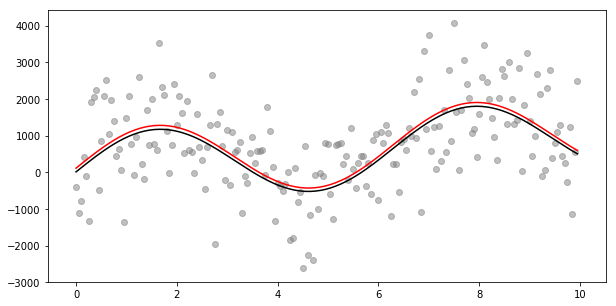

In [38]:
analyze_approximation(t, y_corr)

In [ ]:
y_corr_with_outlier = y_corr.copy()
y_corr_with_outlier[0] += 5000
y_corr_with_outlier[-1] -= 5000

analyze_approximation(t, y_corr_with_outlier)

## Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [39]:
A = np.random.normal(size=(200, 80))
b = np.random.normal(size=(200))

x = solve_overdefined_system(A, b)
print(x)
print(b-A@x)

[ 193.54634721  -61.33737492  -87.94259153 -105.33206796   23.38339955
  -55.83932616  262.3761653    23.27302762  221.06848604   40.60556127
   10.74245647 -143.84592341   92.06023336   -4.2720037   173.26595205
   53.7144967   -37.07293207   55.5390111   -34.62987747   16.21752593
    5.03482379   24.88049579   -2.34624953  176.25079514  -66.73297127
 -139.38546299 -131.1600202    51.80207357  -17.36086406  -27.78089917
  -22.24758521   69.16346273  109.91828452   51.38538382   98.7550692
 -180.56565802  -60.33419119  -46.70008801    5.20310277   -1.16354998
  135.22542128  -92.37080331   79.84002906  -43.27365035    2.28018932
    3.92041527  -43.63910889   44.79295444  196.68790697 -237.29077111
  -82.77532137 -139.11285574 -119.23430482   39.41941524 -118.34000995
  -58.44638889    7.73190868   46.38027693 -173.19304355  -15.485907
  118.511499    111.09547993 -143.4160895  -118.12871879  -56.33597365
  -23.98402276   29.39130022   -0.70128613   53.13382423  -80.1521255
 -149.6143

In [ ]:
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

def plot_ecdf(a):
    counts, bin_edges = np.histogram(a, bins='auto', density=True)
    plt.figure()
    plt.plot(bin_edges[1:], counts)
    plt.plot()
    plt.figure()
    plt.plot(*ecdf(a))

plot_ecdf(b-A@x)

## Бонус +1 Балл
Напишите программу которая для обоих методов из задачи 5 будет использовать 2^n-1 итераций (бонус за каждый метод) и напишите обоснование (итого 0.5 балла за каждый метод)